In [1]:
import time
import numpy as np
import pandas as pd
import shap

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
def run(datasets, 
        metrics, 
        models, 
        load_from_disk, 
        **kwargs):
    
    if load_from_disk:
        similarity_df = pd.read_csv(kwargs['similarity_path'])
        granular_value_df = pd.read_csv(kwargs['gran_value_path'])
        print('loaded from disk')
        return similarity_df, granular_value_df
    else:
        granular_value_df = pd.DataFrame()
        similarity_df = pd.DataFrame()
        for dataset_name, dataset in datasets.items():
            for metric_name, metric_func in metrics.items():
                print(f'dataset: {dataset_name}, metric: {metric_name}')
                logs, vals = compare_cases(dataset=(dataset_name, dataset),
                                           metric=(metric_name, metric_func),
                                           models = models)
                granular_value_df = granular_value_df.append(vals)
                similarity_df = similarity_df.append(logs)

        similarity_df.to_csv(kwargs['similarity_path'])
        granular_value_df.to_csv(kwargs['gran_value_path'])
        print('saved to disk')

        return similarity_df, granular_value_df
    
    
def plot_boxplot(**kwargs):
    sns.boxplot(x = kwargs['x'], 
                y = kwargs['y'], 
                hue = kwargs['hue'],  
                data = kwargs['data'])
    
    ind = kwargs['x']
    dep = kwargs['y']
    
    plt.title(f'By {ind} Comparison', size = 16)
    plt.xlabel(f'{ind}', size = 14)
    plt.ylabel(f'{dep}', size = 14)
    plt.show()
    
def plot_barplots(**kwargs):
    data = kwargs['data']
    dataset_name = kwargs['dataset_name']
    temp = data[data['dataset'] == dataset_name]
    temp = temp[temp['metric'] == kwargs['metric']]
    fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True, sharex=True)
    fig.suptitle(f'Static vs Dynamic FIs (m = accuracy) \n {dataset_name} Dataset', size = 20)

    # Bulbasaur
    g = sns.barplot(ax=axes[0], x = 'shap', y = 'feature', hue = 'model', data = temp)
    g.legend(loc='center right', bbox_to_anchor=(2.6, 0.5), ncol=1)# Charmander
    g = sns.barplot(ax=axes[1], x = 'anwa', y = 'feature', hue = 'model', data = temp)
    
    axes[0].set_xlabel('Shap',fontsize=16);
    axes[0].set_ylabel('Feature',fontsize=16);
    axes[1].set_xlabel('Anwa',fontsize=16);
    axes[1].set_ylabel('',fontsize=16);

    plt.legend([],[], frameon=False)
    plt.show()

### Load Models, Metrics, Datasets


In [3]:
from attribution import compare_cases
from dataloader import fetch_datasets

In [4]:
models = {
    'nn':
    MLPClassifier(random_state=0),
    'logit':
    sklearn.linear_model.LogisticRegression(),
    'rf':
    sklearn.ensemble.RandomForestClassifier(n_estimators=100,
                                            max_depth=None,
                                            min_samples_split=2,
                                            random_state=0),
    'knn':
    sklearn.neighbors.KNeighborsClassifier(),
    'gbc':
    sklearn.ensemble.GradientBoostingClassifier(random_state=0)
}

In [5]:
metrics = {
    'accuracy': lambda Y,Y_hat : accuracy_score(Y,Y_hat), 
    'f1': lambda Y,Y_hat : f1_score(Y,Y_hat,average='weighted', zero_division = 0), 
    'precision': lambda Y,Y_hat : precision_score(Y,Y_hat,average='weighted', zero_division = 0), 
    'recall': lambda Y,Y_hat : recall_score(Y,Y_hat,average='weighted', zero_division = 0), 
}

In [6]:
datasets = fetch_datasets()

### Gen Shap/ANWA. 

In [8]:
similarity_path = './data/similarity.csv'
gran_value_path =  './data/gran_value.csv'

similarity_df, granular_value_df = run(datasets = datasets, 
                                       metrics = metrics, 
                                       models = models, 
                                       load_from_disk = True,
                                       similarity_path = similarity_path,
                                       gran_value_path = gran_value_path)

loaded from disk


### Jaccard Similarity

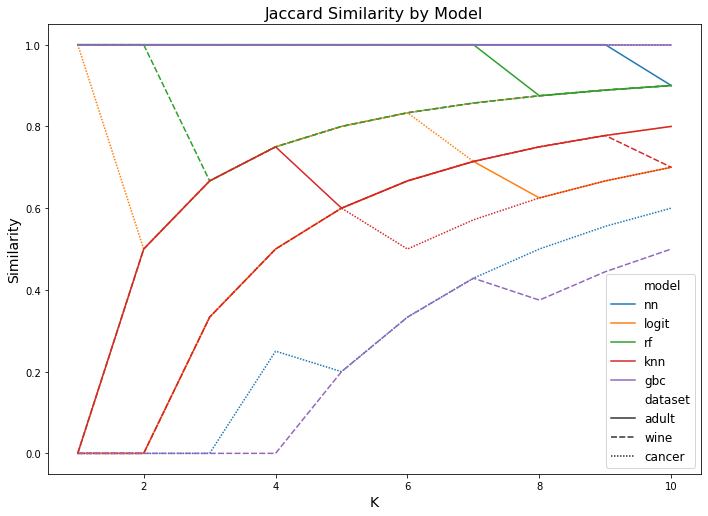

In [9]:
from sklearn.metrics import jaccard_score
from scipy.spatial import distance
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 11.7,8.27
acc = granular_value_df[granular_value_df['metric'] == 'accuracy']


ks = [1,2,3,4,5, 6, 7, 8,9,10] # define the window size
Jaccards = []
for k in ks: 
    for keys in datasets.keys():
        if keys != 'iris':
            for model_key in models.keys():
                data_slice = acc[acc['dataset'] == keys]
                model_slice = data_slice[data_slice['model'] == model_key]
                top_k_shap = model_slice.nlargest(k, 'shap')['feature']
                top_k_anwa = model_slice.nlargest(k, 'anwa')['feature']
                jacc = distance.jaccard(top_k_shap, top_k_anwa)
                Jaccards.append((keys, model_key, k, jacc))

j = pd.DataFrame.from_dict(Jaccards)
j.columns = ['dataset', 'model', 'k', 'Jaccard_Sim']

sns.lineplot(x = 'k', y = 'Jaccard_Sim', hue = 'model', style = 'dataset', data = j)
plt.title('Jaccard Similarity by Model', size = 16)
plt.xlabel('K', size = 14)
plt.ylabel('Similarity', size = 14)
plt.legend(loc='lower right', fontsize='large', title_fontsize='28')
plt.show()

In [10]:
similarity_df.columns = ['ind', 'dataset', 'model', 'metric', 'similarity']

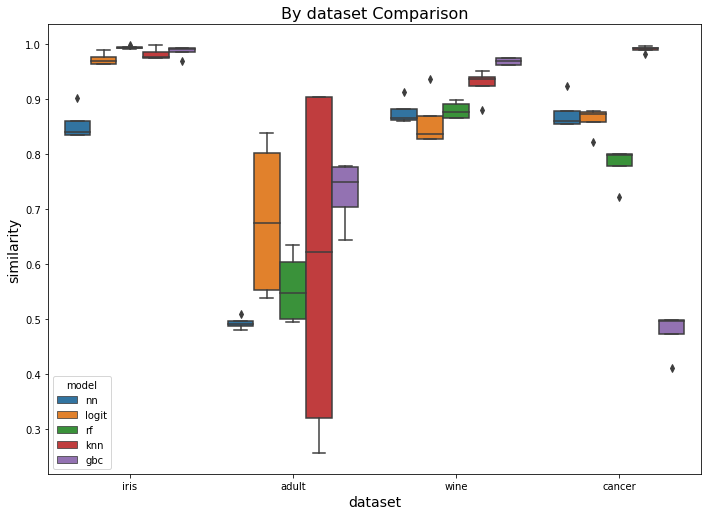

In [11]:
config = {'x':'dataset',
          'y':'similarity',
          'hue':'model',
          'data':similarity_df}

plot_boxplot(**config)

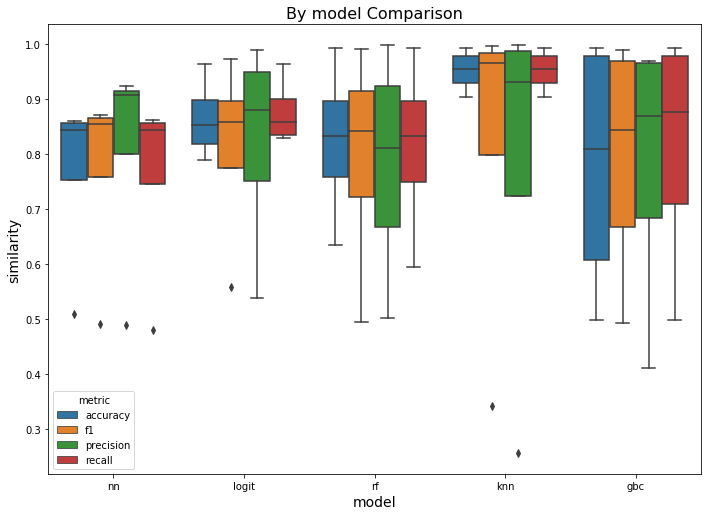

In [12]:
config = {'x':'model',
          'y':'similarity',
          'hue':'metric',
          'data':similarity_df}

plot_boxplot(**config)

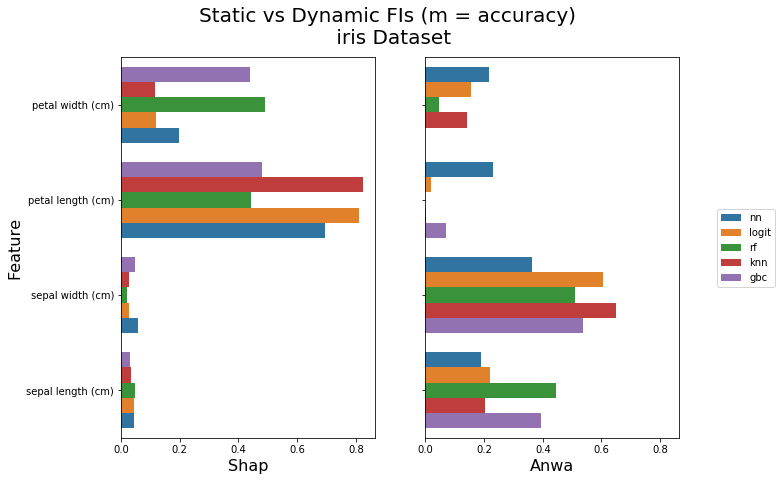

In [13]:
config = {'data': granular_value_df,
          'dataset_name': 'iris',
          'metric': 'accuracy'}

plot_barplots(**config)

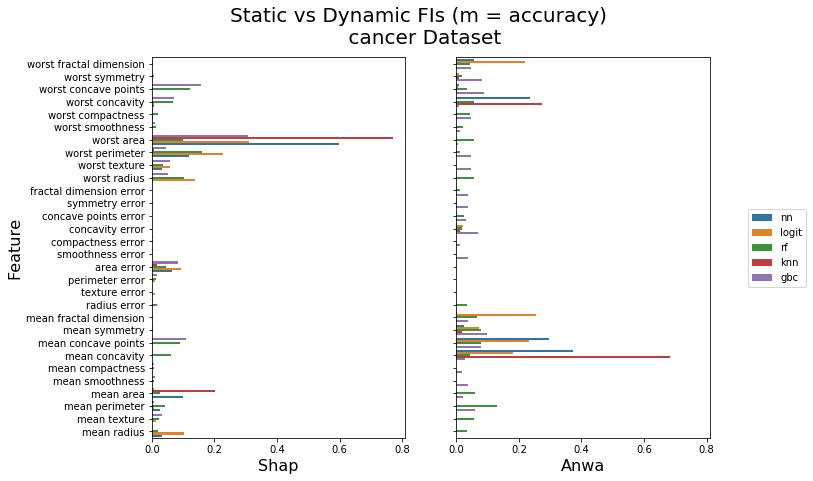

In [14]:
config = {'data': granular_value_df,
          'dataset_name': 'cancer',
          'metric': 'accuracy'}

plot_barplots(**config)

### Multiple Sample Size analysis


In [15]:
from dataloader import fetch_datasets_adult_samples

models = {
    'nn':
    MLPClassifier(random_state=0),
#     'svm':
#     sklearn.svm.SVC(kernel='rbf', probability=True),
#     'logit':
#     sklearn.linear_model.LogisticRegression(),
#     'rf':
#     sklearn.ensemble.RandomForestClassifier(n_estimators=100,
#                                             max_depth=None,
#                                             min_samples_split=2,
#                                             random_state=0),
#     'knn':
#     sklearn.neighbors.KNeighborsClassifier(),
#     'gbc':
#     sklearn.ensemble.GradientBoostingClassifier(random_state=0)
}

metrics = {
    'accuracy': lambda Y,Y_hat : accuracy_score(Y,Y_hat),
}

datasets = fetch_datasets_adult_samples()

In [17]:
similarity_path_adult = f'./data/similarity_adult.csv'
gran_value_path_adult =  f'./data/gran_value_adult.csv'

similarity_df, granular_value_df = run(datasets = datasets, 
                                       metrics = metrics, 
                                       models = models, 
                                       load_from_disk = True,
                                       similarity_path = similarity_path_adult,
                                       gran_value_path = gran_value_path_adult)

loaded from disk


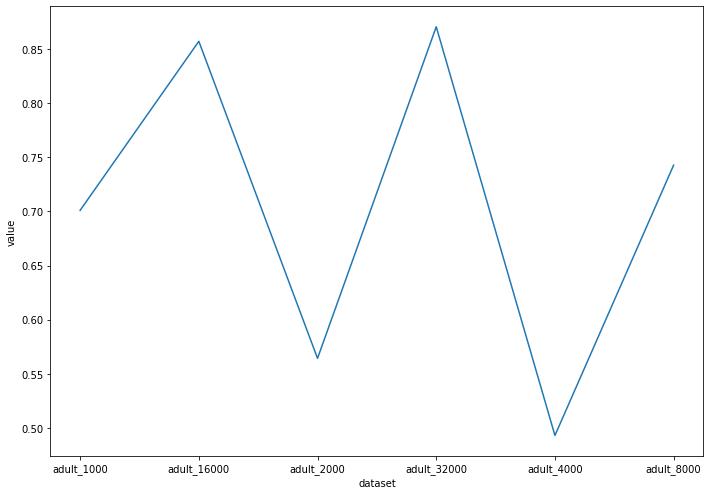

In [18]:
similarity_df.columns = ['index', 'dataset', 'model', 'metric', 'value']
sns.lineplot(x ='dataset', y ='value', data=similarity_df)

In [19]:
similarity_df

,index,dataset,model,metric,value
0,0,adult_1000,nn,accuracy,0.701029
1,0,adult_2000,nn,accuracy,0.564167
2,0,adult_4000,nn,accuracy,0.492878
3,0,adult_8000,nn,accuracy,0.742809
4,0,adult_16000,nn,accuracy,0.857294
5,0,adult_32000,nn,accuracy,0.870743
